In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
plt.style.use("dark_background")

df = pd.read_csv("_data/3_arXiv_Dataset/arxiv_preprocessed.csv")
df.head()

,abstract,update_date,processed_abstract,merged_category
0,A fully differential calculation in perturba...,2008-11-26,fully differential calculation perturbative qu...,High Energy Physics
1,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,describe new algorithm game color use obtain c...,Mathematics
2,The evolution of Earth-Moon system is descri...,2008-01-13,evolution system described dark matter field f...,Physics
3,We show that a determinant of Stirling cycle...,2007-05-23,show determinant stirling cycle number count u...,Mathematics
4,In this paper we show how to compute the $\L...,2013-10-15,paper show compute norm 0 using dyadic grid re...,Mathematics


In [3]:
text_column = 'processed_abstract'
category_column = 'merged_category'

df = df.sample(400000, random_state=42)
df = df.dropna()

X = df[text_column]
y = df[category_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Linear SVM

Classification Report:
                                   precision    recall  f1-score   support

         Astrophysics & Cosmology       0.92      0.92      0.92     11342
                 Computer Science       0.84      0.91      0.87     17771
              Economics & Finance       0.65      0.53      0.59       620
            Engineering & Systems       0.52      0.25      0.34      1740
              High Energy Physics       0.85      0.85      0.85      8593
                    Life Sciences       0.62      0.46      0.53       923
                      Mathematics       0.85      0.92      0.88     15742
                  Nuclear Physics       0.78      0.64      0.70      1340
                          Physics       0.85      0.87      0.86     15910
                  Quantum Physics       0.80      0.74      0.77      3462
Statistics & Mathematical Physics       0.64      0.32      0.43      2557

                         accuracy                           0.85     80000


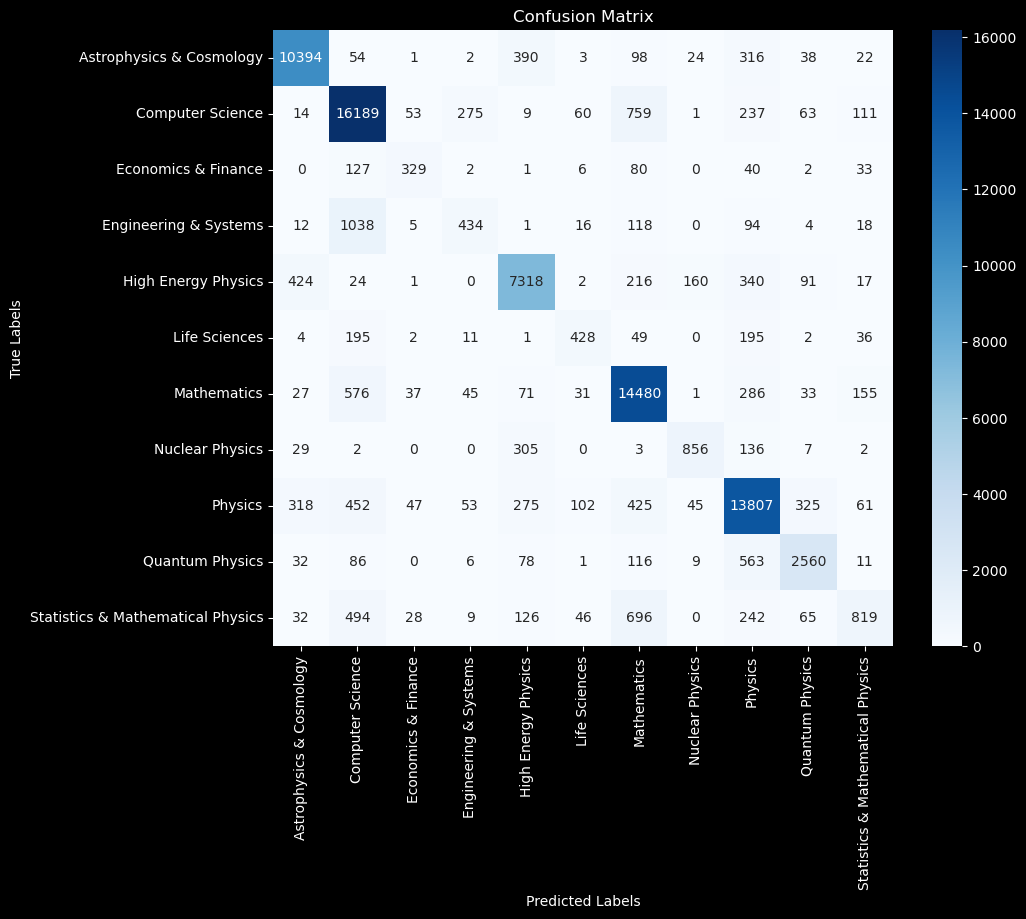

Top 20 features for Astrophysics & Cosmology: telescope, accretion, galaxy, blazars, agn, interstellar, nebula, spectrograph, sunspot, flare, stellar, photometric, photosphere, photospheric, quasar, astronomy, photometry, observatory, star, exoplanet
Top 20 features for Computer Science: robot, concurrent, robotic, monocular, robotics, reasoning, checking, fading, designer, discovering, language, scene, code, bug, summarization, grammar, architectural, editing, mining, granularity
Top 20 features for Economics & Finance: economic, portfolio, financial, trading, asset, option, default, implement, empirical, imposes, implied, usefulness, investigates, bank, consistently, bond, instrument, perfectly, volatility, choice
Top 20 features for Engineering & Systems: sed, radar, mri, diagnosis, pathology, shaped, hosting, denoising, winding, proposed, speaker, speech, percent, imaging, brought, ct, selecting, decoupling, voltage, control
Top 20 features for High Energy Physics: holographic, sup

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train an SVM classifier
svm_classifier = LinearSVC(dual='auto')
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
categories = sorted(df[category_column].unique())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Check most important features for each category
def get_top_features(vectorizer, classifier, category_names, n_top=20):
    feature_names = vectorizer.get_feature_names_out()

    # For OneVsRestClassifier, access estimators_ attribute
    if hasattr(classifier, 'estimators_'):
        estimators = classifier.estimators_
    else:
        # If it's a direct LinearSVC
        estimators = [classifier]

    for i, category in enumerate(category_names):
        if i < len(estimators):
            estimator = estimators[i]
            if hasattr(estimator, 'coef_'):
                top_indices = np.argsort(estimator.coef_[0])[-n_top:]
                top_features = [feature_names[j] for j in top_indices]
                print(f"Top {n_top} features for {category}: {', '.join(top_features[::-1])}")

ovr_classifier = OneVsRestClassifier(LinearSVC(dual='auto'))
ovr_classifier.fit(X_train_tfidf, y_train)
get_top_features(tfidf_vectorizer, ovr_classifier, categories)

# Multinomial Naive Bayes

Naive Bayes Classification Report:
                                   precision    recall  f1-score   support

         Astrophysics & Cosmology       0.93      0.84      0.88     11342
                 Computer Science       0.77      0.90      0.83     17771
              Economics & Finance       0.67      0.37      0.48       620
            Engineering & Systems       0.47      0.15      0.23      1740
              High Energy Physics       0.79      0.84      0.81      8593
                    Life Sciences       0.66      0.31      0.42       923
                      Mathematics       0.80      0.90      0.85     15742
                  Nuclear Physics       0.78      0.47      0.59      1340
                          Physics       0.82      0.84      0.83     15910
                  Quantum Physics       0.85      0.57      0.68      3462
Statistics & Mathematical Physics       0.53      0.26      0.35      2557

                         accuracy                           0.8

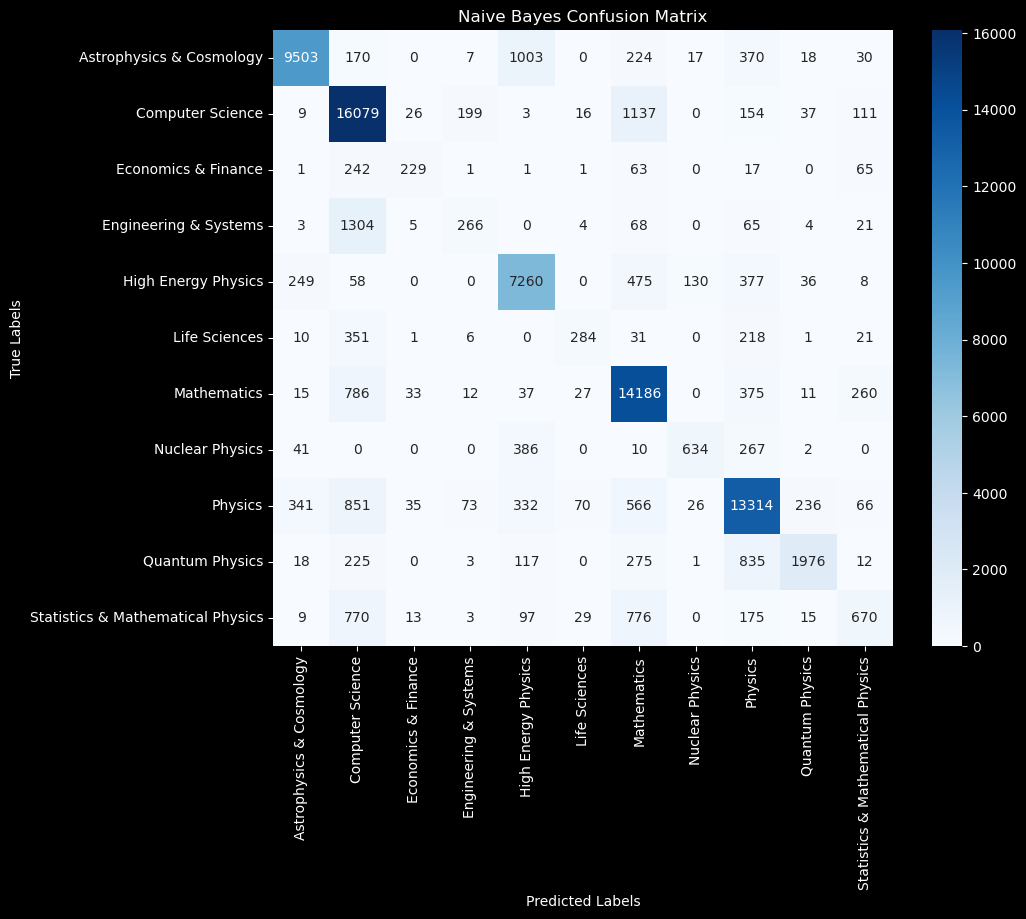


Comparison between SVM and Naive Bayes:
SVM Accuracy: 0.8452
Naive Bayes Accuracy: 0.8050


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

y_pred_nb = nb_classifier.predict(X_test_tfidf)

# Evaluate the model
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Create and plot confusion matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
categories = sorted(df[category_column].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

print("\nComparison between SVM and Naive Bayes:")
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")

# Random Forest

Random Forest Classification Report:
                                   precision    recall  f1-score   support

         Astrophysics & Cosmology       0.91      0.88      0.90     11342
                 Computer Science       0.74      0.93      0.83     17771
              Economics & Finance       0.82      0.10      0.18       620
            Engineering & Systems       0.79      0.01      0.01      1740
              High Energy Physics       0.83      0.80      0.82      8593
                    Life Sciences       1.00      0.00      0.01       923
                      Mathematics       0.81      0.90      0.85     15742
                  Nuclear Physics       0.93      0.26      0.41      1340
                          Physics       0.77      0.85      0.81     15910
                  Quantum Physics       0.82      0.60      0.70      3462
Statistics & Mathematical Physics       0.76      0.08      0.15      2557

                         accuracy                           0

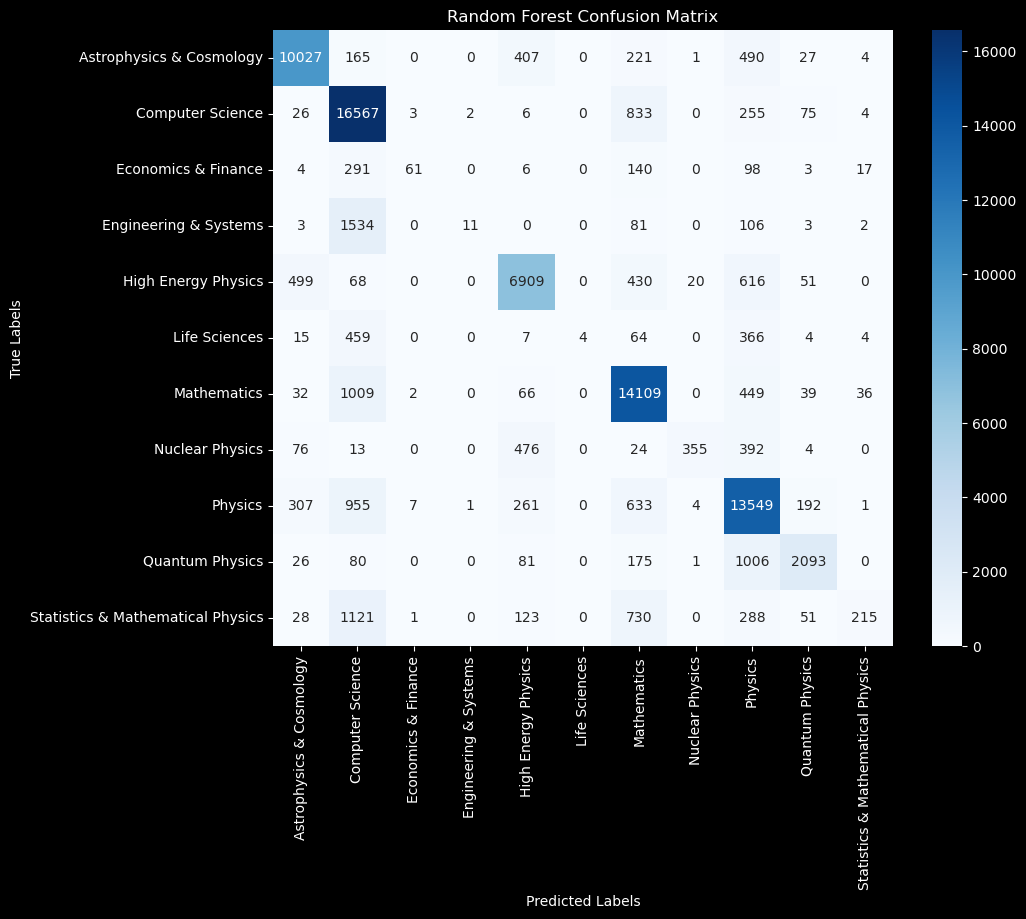


Model Comparison:
SVM Accuracy: 0.8452
Naive Bayes Accuracy: 0.8050
Random Forest Accuracy: 0.7987


In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

y_pred_rf = rf_classifier.predict(X_test_tfidf)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

print("\nModel Comparison:")
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

# Feature importance for random forest

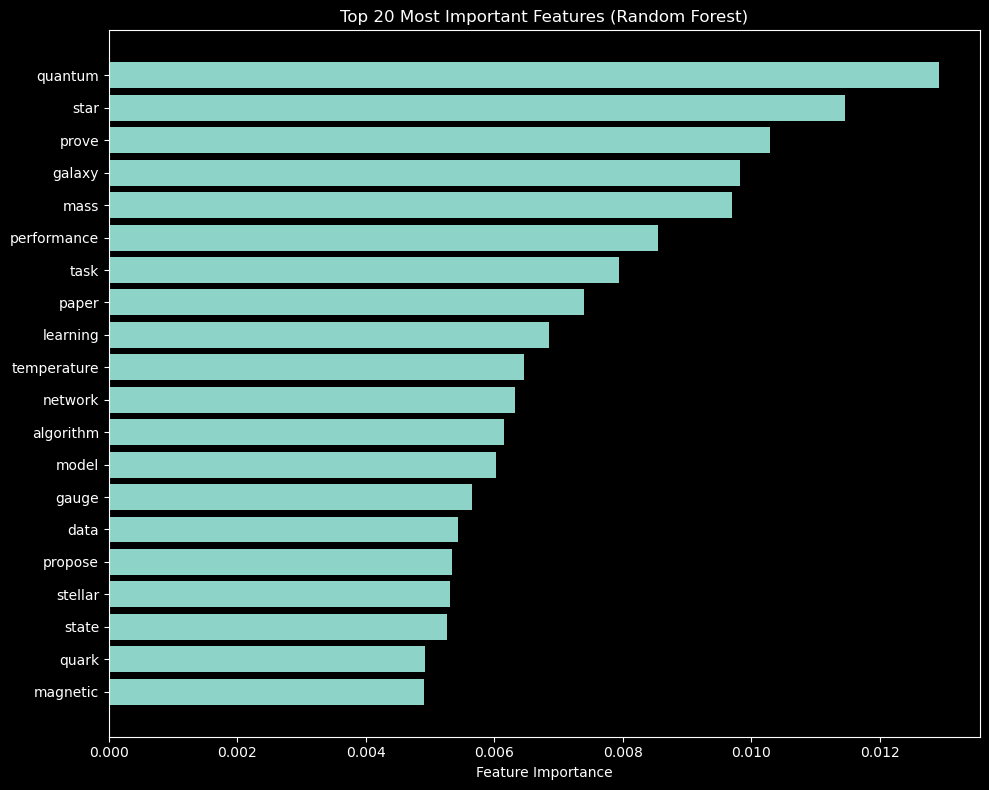

In [7]:
# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Plot top 20 most important features overall
feature_importances = rf_classifier.feature_importances_
sorted_idx = np.argsort(feature_importances)[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# Coefficients from SVM Model

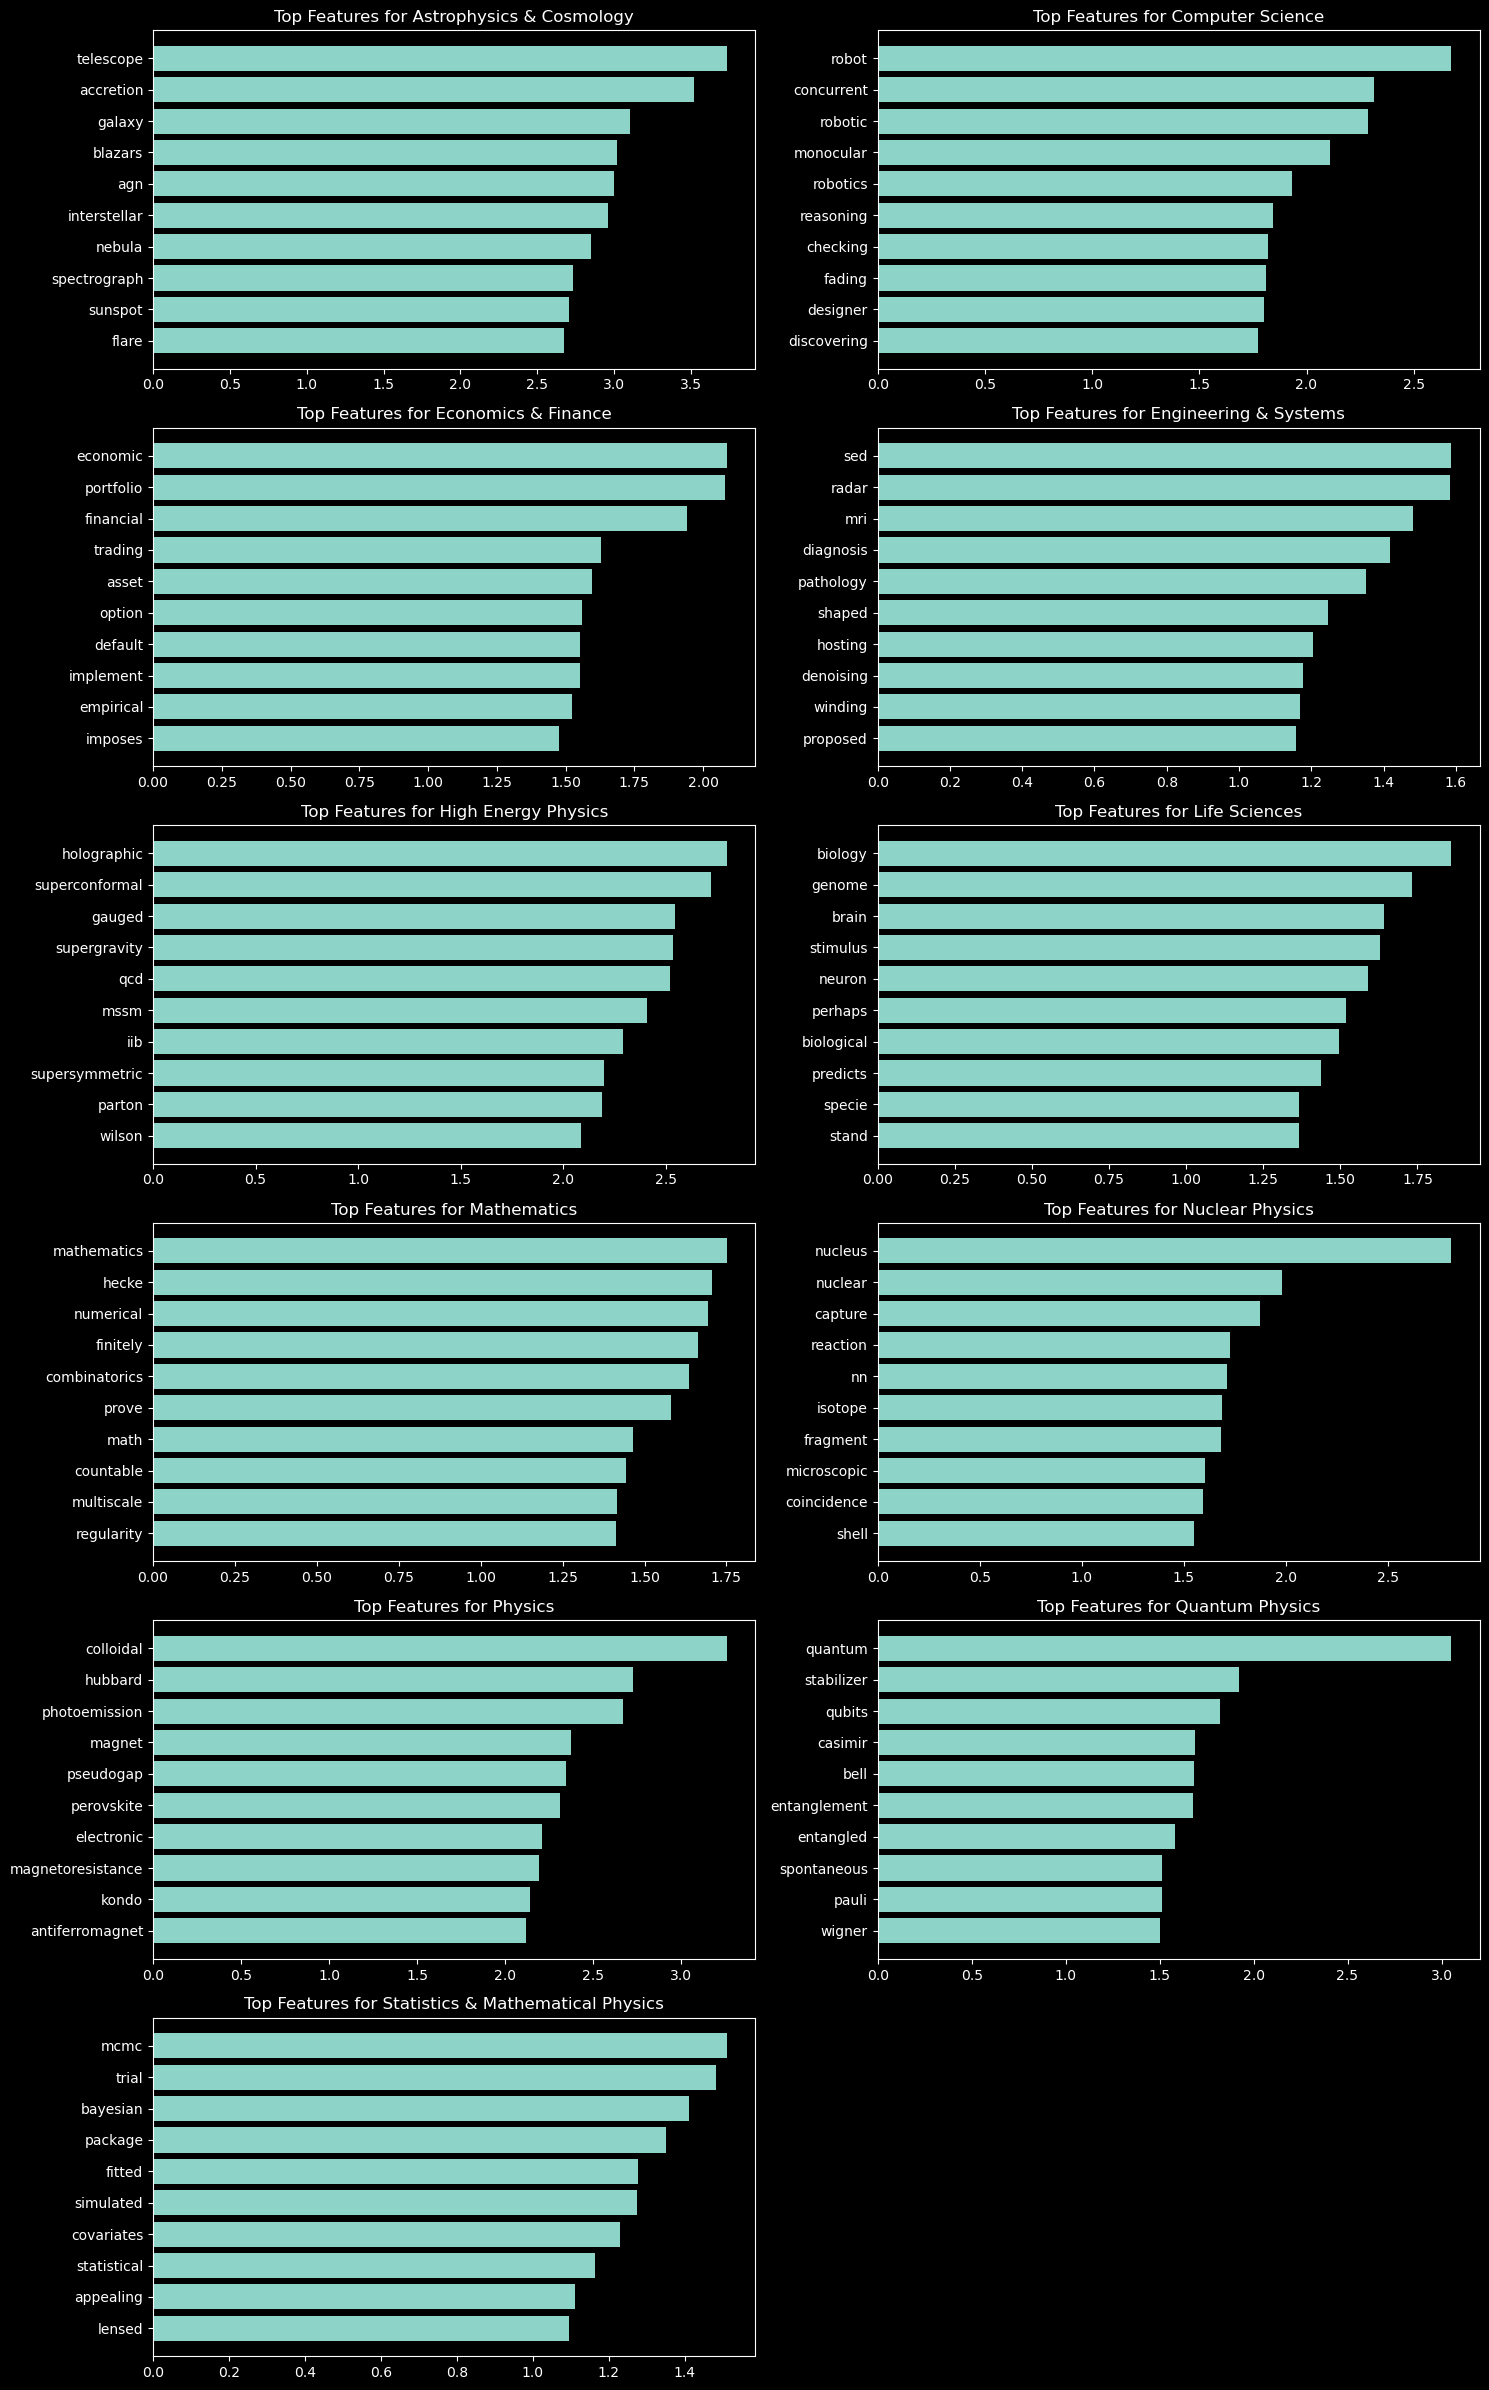

In [8]:
# Get the top features for each category from SVM
def plot_top_features_per_category(classifier, feature_names, categories, top_n=10):
    # Calculate required grid size
    n_categories = len(categories)
    n_cols = 2
    n_rows = (n_categories + n_cols - 1) // n_cols  # Ceiling division to make sure we have enough rows

    plt.figure(figsize=(15, 4 * n_rows))

    for i, category in enumerate(categories):
        coefficients = classifier.coef_[i]
        top_indices = np.argsort(coefficients)[-top_n:]

        plt.subplot(n_rows, n_cols, i+1)
        plt.barh(range(top_n), coefficients[top_indices])
        plt.yticks(range(top_n), [feature_names[j] for j in top_indices])
        plt.title(f'Top Features for {category}')

    plt.tight_layout()
    plt.show()

# Make sure categories are in the same order as classifier's classes
categories = svm_classifier.classes_
plot_top_features_per_category(svm_classifier, feature_names, categories)

# Conditional Probabilities from Naive Bayes

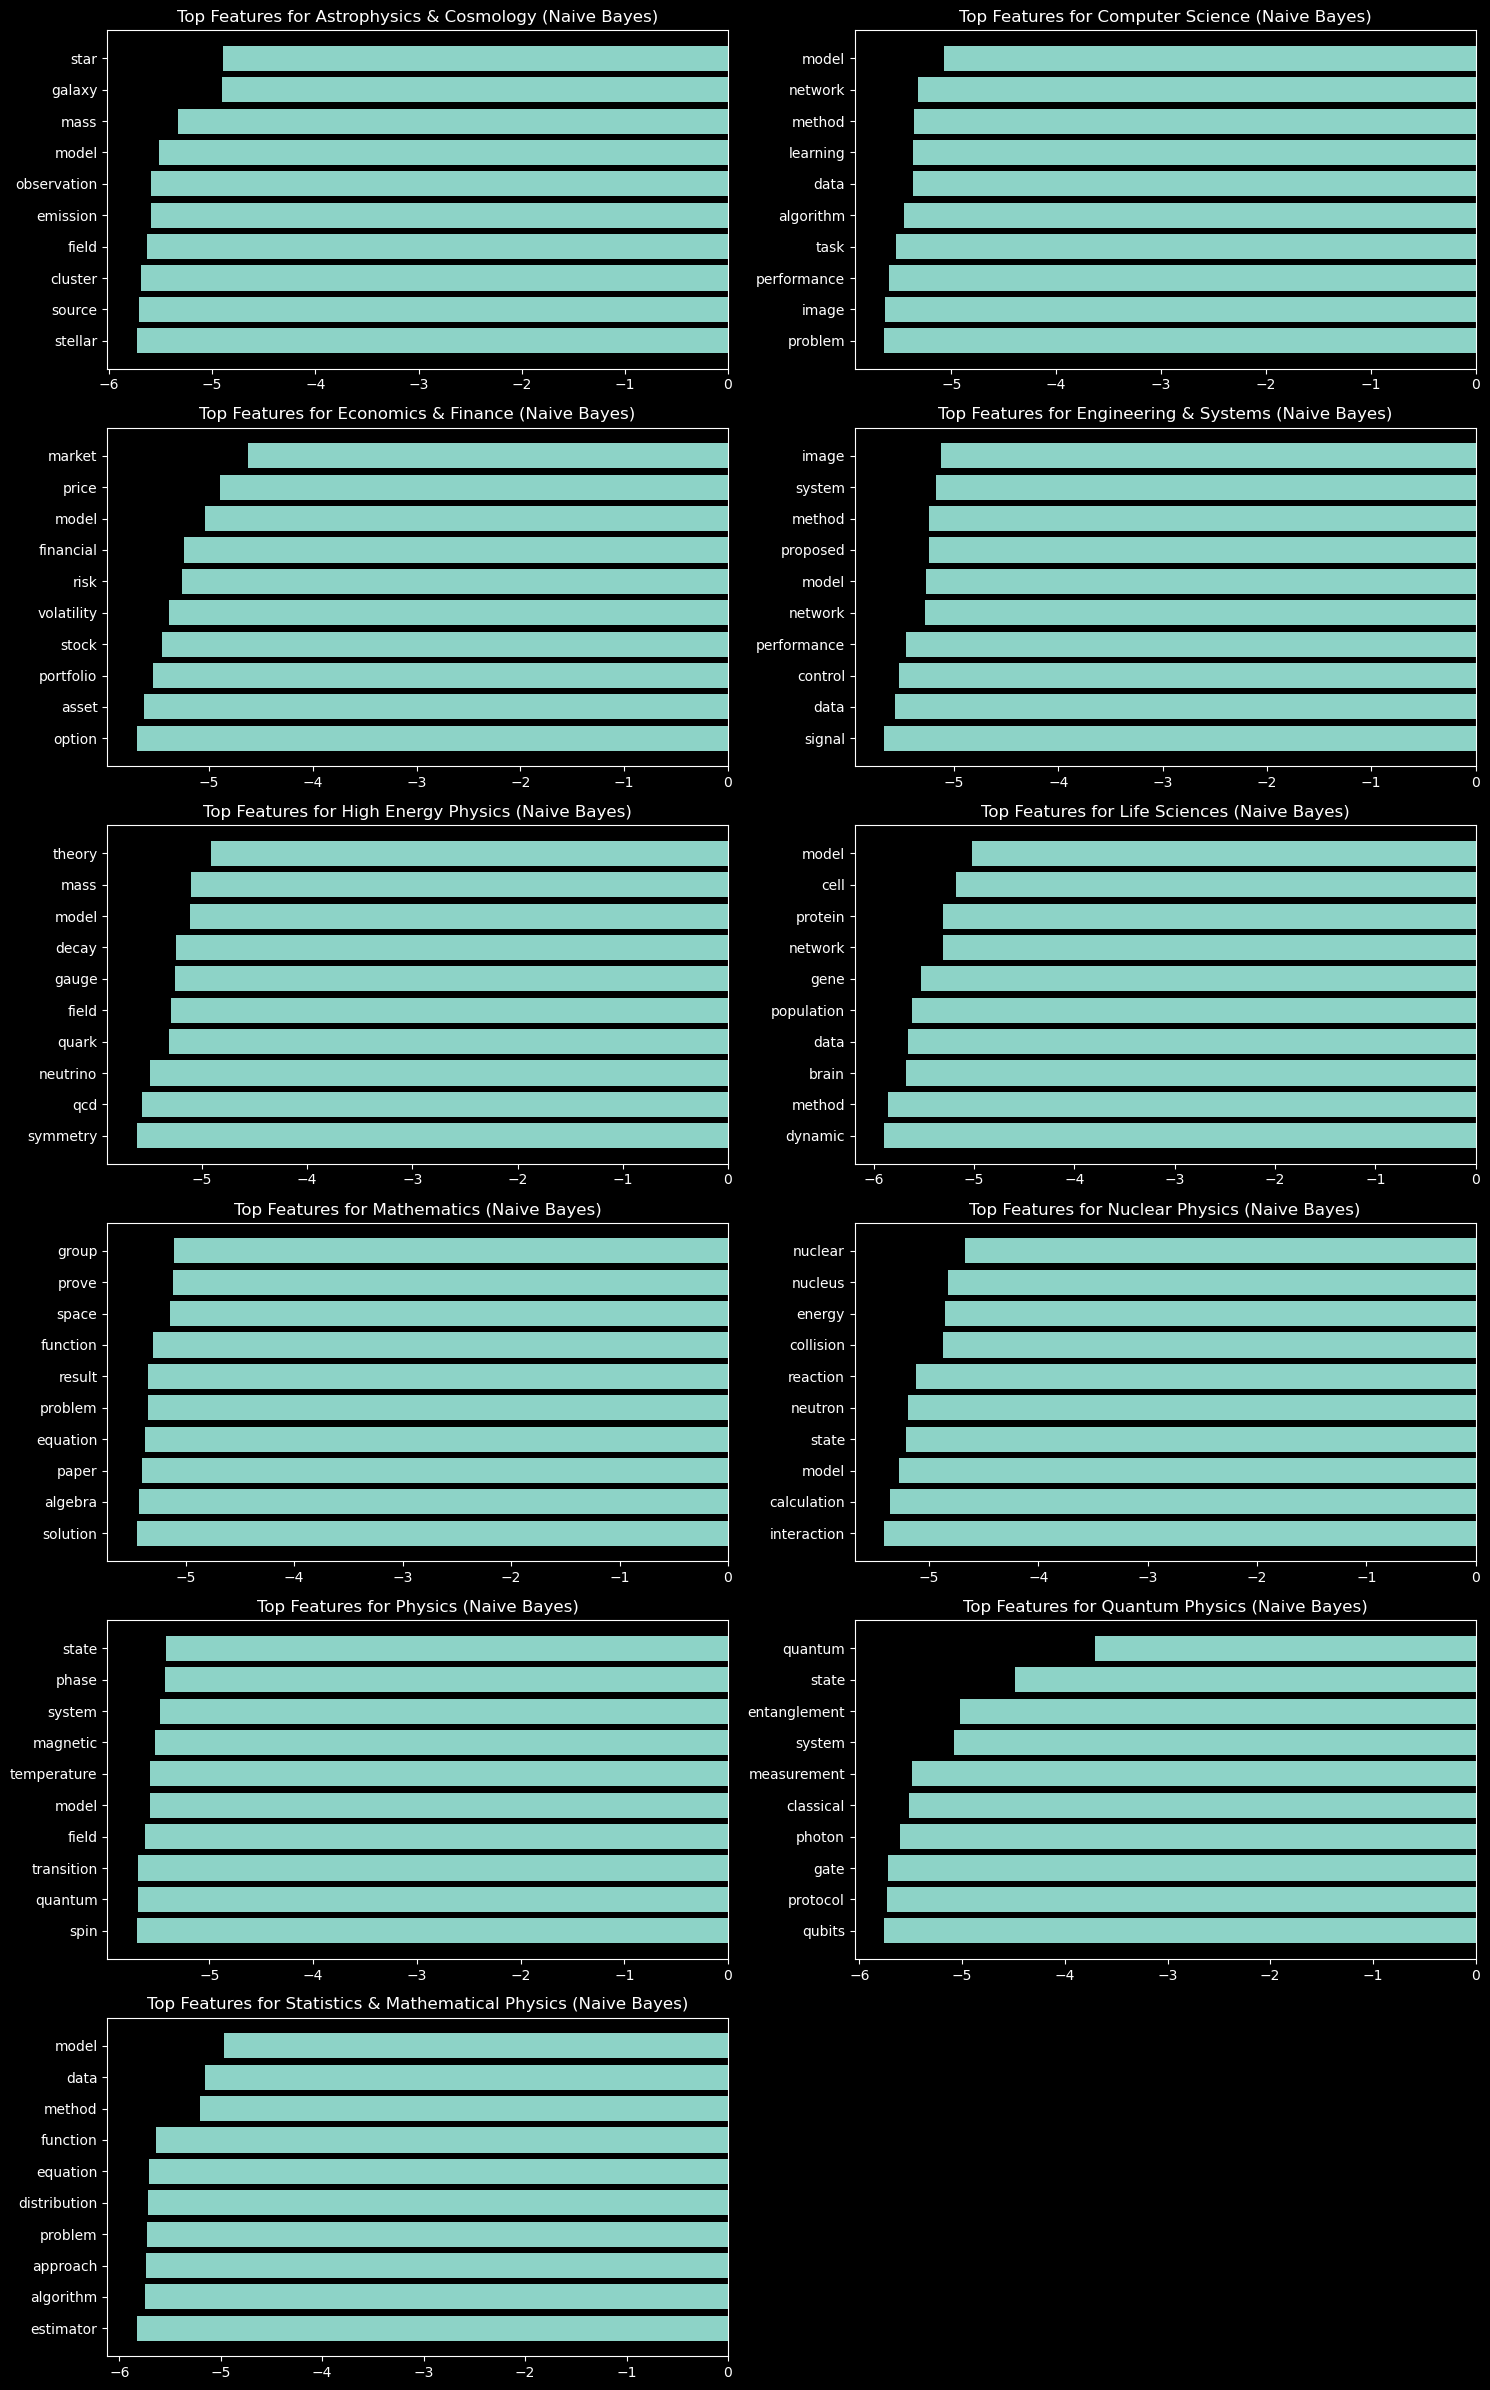

In [9]:
def plot_naive_bayes_features(nb_classifier, feature_names, categories, top_n=10):
    # Calculate required grid size
    n_categories = len(categories)
    n_cols = 2  # You can adjust this
    n_rows = (n_categories + n_cols - 1) // n_cols  # Ceiling division for enough rows

    plt.figure(figsize=(15, 4 * n_rows))
    feature_log_probs = nb_classifier.feature_log_prob_

    for i, category in enumerate(categories):
        # Get the log probabilities for this category
        log_probs = feature_log_probs[i]
        # Find indices of top features for this category
        top_indices = np.argsort(log_probs)[-top_n:]

        plt.subplot(n_rows, n_cols, i+1)
        plt.barh(range(top_n), log_probs[top_indices])
        plt.yticks(range(top_n), [feature_names[j] for j in top_indices])
        plt.title(f'Top Features for {category} (Naive Bayes)')

    plt.tight_layout()
    plt.show()

# Make sure categories are in the order of classifier's classes
categories = nb_classifier.classes_
plot_naive_bayes_features(nb_classifier, feature_names, categories)

# Word Clouds for Each Category

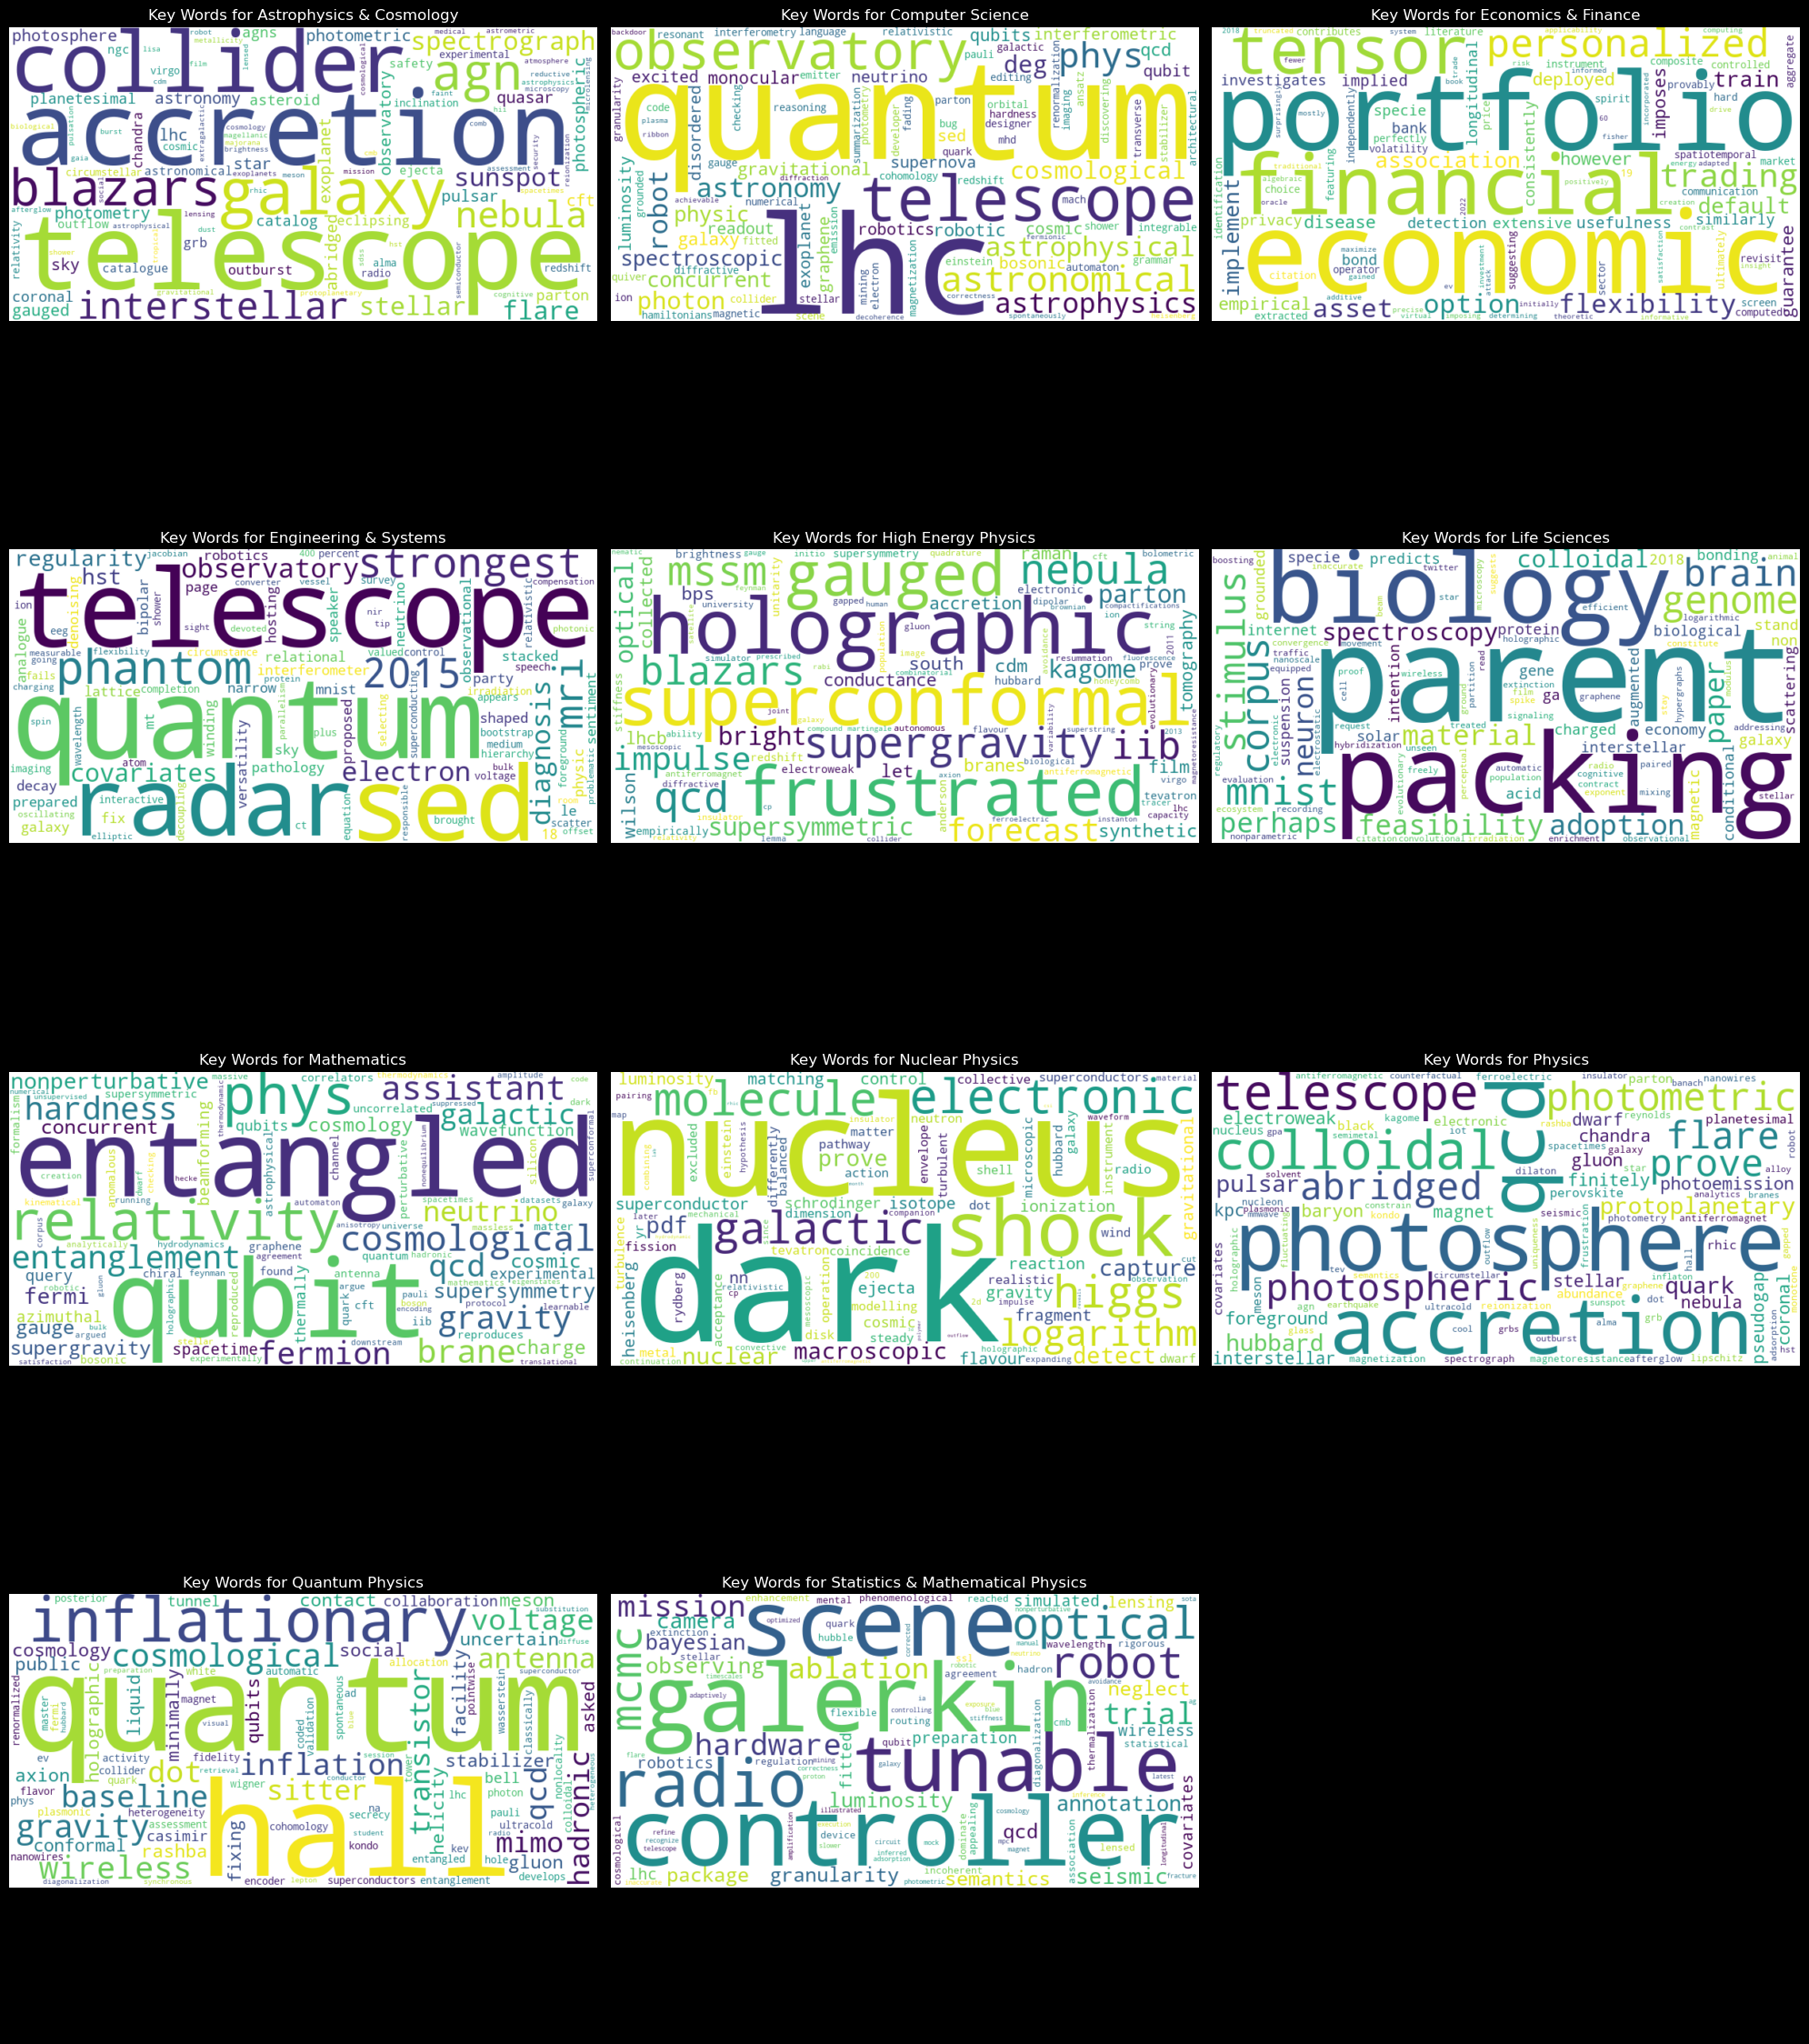

In [10]:
from wordcloud import WordCloud

def plot_category_wordclouds(vectorizer, classifier, categories):
    feature_names = vectorizer.get_feature_names_out()

    # Calculate required grid size
    n_categories = len(categories)
    n_cols = 3  # You can adjust this
    n_rows = (n_categories + n_cols - 1) // n_cols  # Ceiling division for enough rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        if i < len(classifier.classes_):
            # Get the feature weights for this category
            if hasattr(classifier, 'coef_'):
                weights = classifier.coef_[i]
            elif hasattr(classifier, 'feature_importances_'):
                weights = classifier.feature_importances_
            else:
                continue

            # Create a dictionary of word:weight
            word_weights = {feature_names[j]: abs(weights[j]) for j in range(len(feature_names))}

            # Generate a word cloud
            wordcloud = WordCloud(width=800, height=400,
                                 background_color='white',
                                 max_words=100).generate_from_frequencies(word_weights)

            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'Key Words for {category}')
            axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# For SVM
plot_category_wordclouds(tfidf_vectorizer, svm_classifier, svm_classifier.classes_)

# T-SNE Visualization of Document Vectors

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
# Combine train and test data for visualization
X_combined = np.vstack([X_train_tfidf.toarray(), X_test_tfidf.toarray()])
y_combined = np.concatenate([y_train, y_test])

# Reduce the dimensionality
X_tsne = tsne.fit_transform(X_combined)
# Create a dataframe for plotting
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df[category_column] = y_combined

plt.figure(figsize=(12, 10))
for category in tsne_df[category_column].unique():
    subset = tsne_df[tsne_df[category_column] == category]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=category, alpha=0.6)

plt.legend()
plt.title('t-SNE Visual of TF-IDF Features')
plt.show()